<a href="https://colab.research.google.com/github/OrizaSativaFiojati/Flikr8K_Image_Captions/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Library

In [ ]:
import numpy as np
import pandas as pd
import zipfile, os
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt

from keras.utils import pad_sequences, to_categorical, plot_model
from keras.models import Model, Sequential
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Flatten, Convolution2D, TimeDistributed, Bidirectional, RepeatVector, Concatenate, add
from keras.callbacks import ModelCheckpoint
from keras.applications import ResNet50

# Data Collection

In [ ]:
!wget --no-check-certificate \
https://dl.dropbox.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2 \
-O /archive.zip

--2023-05-21 09:35:49--  https://dl.dropbox.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2
Resolving dl.dropbox.com (dl.dropbox.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropbox.com (dl.dropbox.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://dl.dropboxusercontent.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2 [following]
--2023-05-21 09:35:49--  https://dl.dropboxusercontent.com/s/rems3rh5a96023s/Flickr_Data.zip?dl=2
Resolving dl.dropboxusercontent.com (dl.dropboxusercontent.com)... 162.125.1.15, 2620:100:6016:15::a27d:10f
Connecting to dl.dropboxusercontent.com (dl.dropboxusercontent.com)|162.125.1.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1114560631 (1.0G) [application/zip]
Saving to: ‘/archive.zip’

/archive.zip        100%[===================>]   1.04G   103MB/s    in 9.4s    

2023-05-21 09:35:59 (113 MB/s) - ‘/archive.zip’ saved [1114560631/1114560631]



In [ ]:
# Mengesktrak folder zip yang telah terdownload
local_zip = '/archive.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/')
zip_ref.close()

base_dir = '/archive'

In [ ]:
images_path = '/Flickr_Data/Images/'
images = glob(images_path+'*.jpg')
len(images)

8091

In [ ]:
images[:5]

['/Flickr_Data/Images/2540751930_d71c7f5622.jpg',
 '/Flickr_Data/Images/540721368_12ac732c6c.jpg',
 '/Flickr_Data/Images/2409312675_7755a7b816.jpg',
 '/Flickr_Data/Images/2553024095_735bc46267.jpg',
 '/Flickr_Data/Images/2713897716_c8cd610360.jpg']

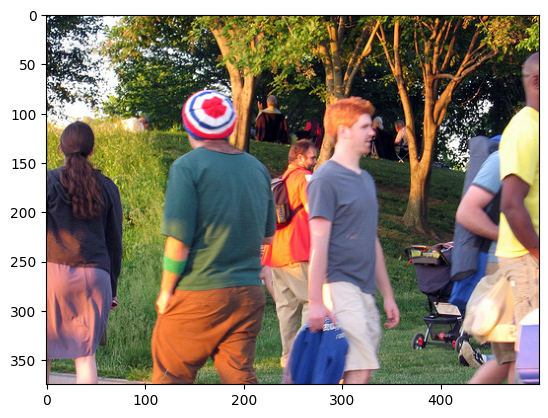

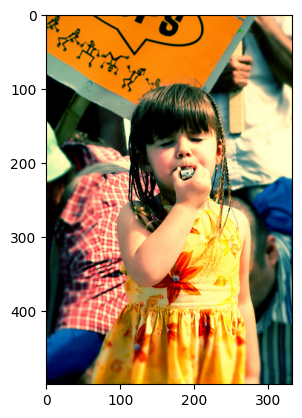

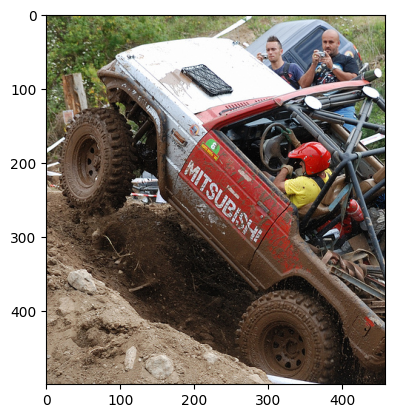

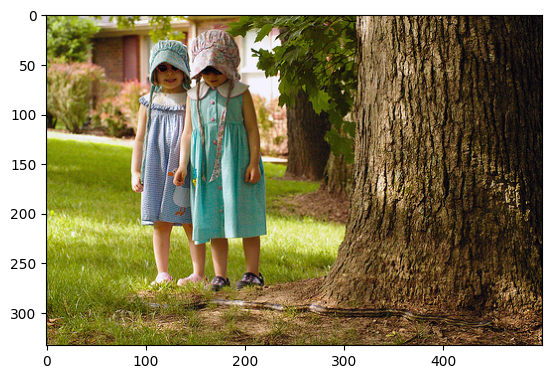

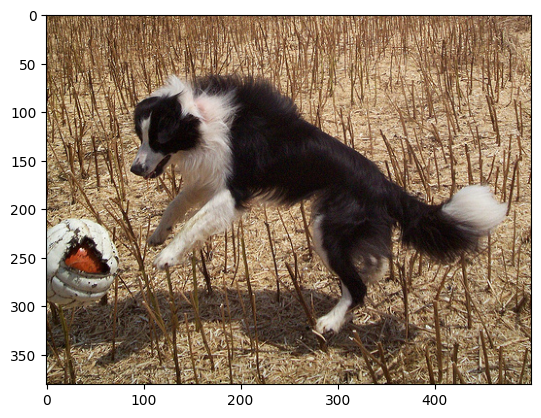

In [ ]:
for i in range(5):
  plt.figure()
  img = cv2.imread(images[i])
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)

# Image Processing

In [ ]:
incept_model = ResNet50(include_top = True)
last = incept_model.layers[-2].output
modele = Model(inputs = incept_model.input,outputs = last)
modele.summary()

102967424/102967424 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                           

In [ ]:
images_features = {}
count = 0
for i in images:
  img = cv2.imread(i)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224,224))

  img = img.reshape(1,224,224,3)
  pred = modele.predict(img).reshape(2048,)

  img_name = i.split('/')[-1]
  
  images_features[img_name] = pred

  count += 1
  if count > 1499:
    break
  elif count % 50 == 0:
    print(count)

1/1 [==============================] - 0s 21ms/step
50
1/1 [==============================] - 0s 22ms/step
100
1/1 [==============================] - 0s 31ms/step
150
1/1 [==============================] - 0s 22ms/step
200
1/1 [==============================] - 0s 22ms/step
250
1/1 [==============================] - 0s 35ms/step
300
1/1 [==============================] - 0s 21ms/step
350
1/1 [==============================] - 0s 20ms/step
400
1/1 [==============================] - 0s 21ms/step
450
1/1 [==============================] - 0s 22ms/step
500
1/1 [==============================] - 0s 25ms/step
550
1/1 [==============================] - 0s 23ms/step
600
1/1 [==============================] - 0s 33ms/step
650
1/1 [==============================] - 0s 23ms/step
700
1/1 [==============================] - 0s 21ms/step
750
1/1 [==============================] - 0s 36ms/step
800
1/1 [==============================] - 0s 22ms/step
850
1/1 [==============================] - 0s 23ms/st

# Text Preprocess

In [ ]:
caption_path = '/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'

In [ ]:
captions = open(caption_path, 'rb').read().decode('utf-8').split('\n')

In [ ]:
len(captions)

40461

In [ ]:
captions_dict = {}
for i in captions:
  try:
    img_name = i.split('\t')[0][:-2]
    caption = i.split('\t')[1]
    if img_name in images_features:
      if img_name not in captions_dict:
        captions_dict[img_name] = [caption]
      else:
        captions_dict[img_name].append(caption)
  except:
    pass

# Visualisasi Image

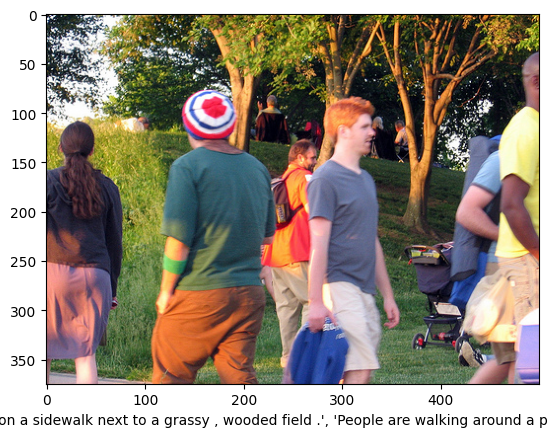

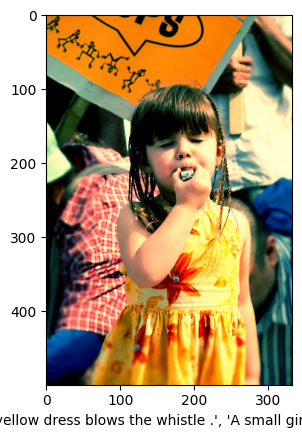

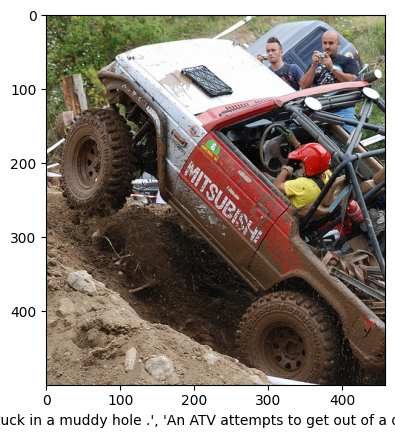

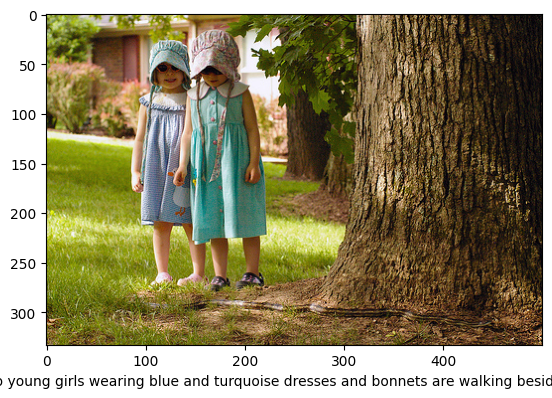

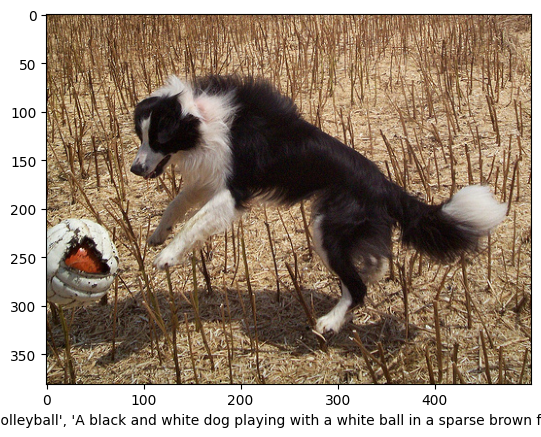

In [ ]:
for i in range(5):
  plt.figure()
  img_name = images[i]
  img = cv2.imread(img_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.xlabel(captions_dict[img_name.split('/')[-1]])
  plt.imshow(img)

In [ ]:
def preprocessed(txt):
  modified = txt.lower()
  modified = 'startofseq ' + modified + ' endofseq'
  return modified

In [ ]:
for k,v in captions_dict.items():
  for vv in v:
    captions_dict[k][v.index(vv)] = preprocessed(vv)

# Membuat vocabulary

In [ ]:
count_words = {} 
for k,vv in captions_dict.items():
  for v in vv:
    for word in v.split():
      if word not in count_words:
        count_words[word] = 0
      else:
        count_words[word] += 1

In [ ]:
len(count_words)

4015

In [ ]:
THRESH = -1
count = 1
new_dict = {}
for k,v in count_words.items():
  if count_words[k]>THRESH:
    new_dict[k] = count
    count += 1

In [ ]:
len(new_dict)

4015

In [ ]:
new_dict['<OUT>'] =len(new_dict)

In [ ]:
captions_backup = captions_dict.copy()

In [ ]:
captions_dict = captions_backup.copy()

In [ ]:
for k, vv in captions_dict.items():
  for v in vv:
    encode = []
    for word in v.split():
      if word not in new_dict:
        encode.append(new_dict['<OUT>'])
      else :
        encode.append(new_dict[word])
    captions_dict[k][vv.index(v)] = encode

In [ ]:
batch_size = 5000
VOCAB_SIZE = len(new_dict)

def generator(photo, caption):
  n_samples = 0

  X = []
  y_in = []
  y_out = []

  for k, vv in caption.items():
    for v in vv :
      for i in range (1, len(v)):
        X.append(photo[k])
        in_seq = [v[:i]]
        out_seq = v[i]

        in_seq = pad_sequences(in_seq, maxlen=40, padding='post', truncating='post')[0]
        out_seq = to_categorical([out_seq], num_classes=VOCAB_SIZE)[0]

        y_in.append(in_seq)
        y_out.append(out_seq)
  return X, y_in, y_out

In [ ]:
X, y_in, y_out = generator(images_features, captions_dict)

In [ ]:
len(X), len(y_in), len(y_out)

(95497, 95497, 95497)

In [ ]:
X = np.array(X)
y_in = np.array(y_in, dtype='float64')
y_out = np.array(y_out, dtype='float64')

#Modelling

In [ ]:
from keras.layers.core.activation import Activation
embedding_size = 128
max_len = 40
vocab_size = len(new_dict)

image_model = Sequential()
image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))
image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
language_model = Sequential()
language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))
language_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           514048    
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDistr  (None, 40, 128)          32896     
 ibuted)                                                         
                                                                 
Total params: 941,184
Trainable params: 941,184
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

#model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      514048      ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                            

In [ ]:
model.fit([X, y_in], y_out, batch_size=512, epochs=250)

Epoch 1/250
187/187 [==============================] - 35s 139ms/step - loss: 5.3214 - accuracy: 0.1148
Epoch 2/250
187/187 [==============================] - 21s 111ms/step - loss: 5.1496 - accuracy: 0.1179
Epoch 3/250
187/187 [==============================] - 18s 99ms/step - loss: 5.0881 - accuracy: 0.1186
Epoch 4/250
187/187 [==============================] - 18s 98ms/step - loss: 5.0286 - accuracy: 0.1187
Epoch 5/250
187/187 [==============================] - 18s 97ms/step - loss: 4.9739 - accuracy: 0.1186
Epoch 6/250
187/187 [==============================] - 18s 99ms/step - loss: 4.9279 - accuracy: 0.1188
Epoch 7/250
187/187 [==============================] - 18s 97ms/step - loss: 4.8808 - accuracy: 0.1185
Epoch 8/250
187/187 [==============================] - 18s 97ms/step - loss: 4.8392 - accuracy: 0.1183
Epoch 9/250
187/187 [==============================] - 18s 95ms/step - loss: 4.8009 - accuracy: 0.1190
Epoch 10/250
187/187 [==============================] - 18s 96ms/step -

In [ ]:
inv_dict = {v:k for k, v in new_dict.items()}

In [ ]:
model.save('model.h5')

In [ ]:
model.save_weights('mine_model_weights.h5')

In [ ]:
np.save('vocab.npy', new_dict)

In [ ]:
def getImage(x):
  test_img_path = images[x]
  test_img = cv2.imread(test_img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
  test_img = cv2.resize(test_img, (299,299))
  test_img = np.reshape(test_img, (1, 299,299, 3))
  return test_img

1/1 [==============================] - 0s 31ms/step


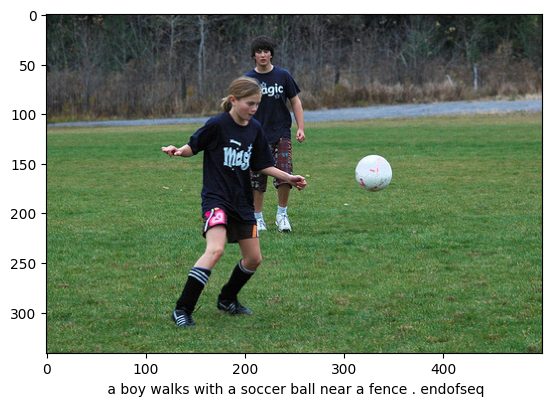

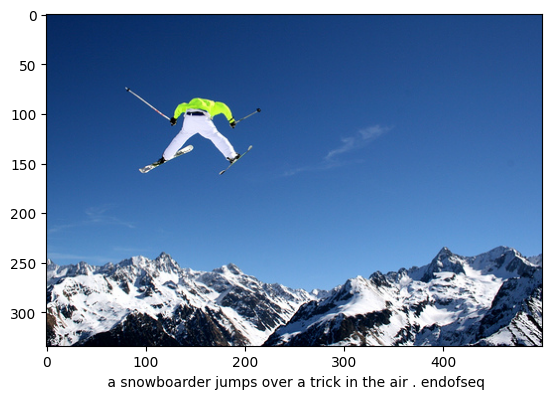

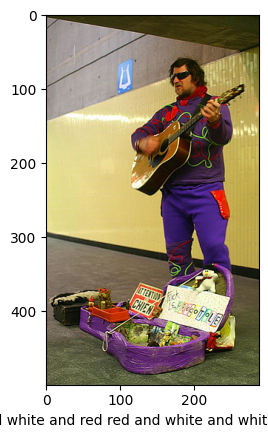

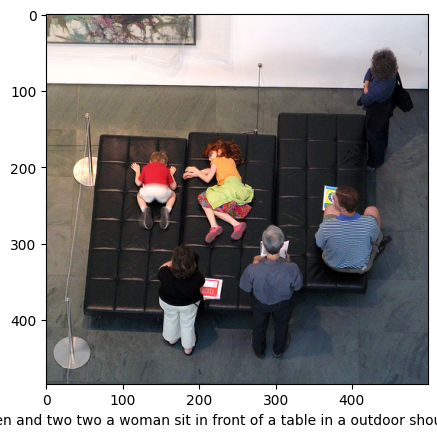

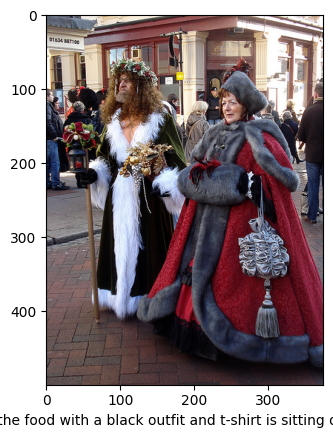

In [ ]:
for i in range(5) :

    no = np.random.randint(1500,7000,(1,1))[0,0]
    test_feature = modele.predict(getImage(no)).reshape(1,2048)

    test_img_path = images[no]
    test_img = cv2.imread(test_img_path)
    test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

    text_inp = ['startofseq']

    count = 0
    caption = ''
    while count < 25:
        count += 1

        encoded = []
        for i in text_inp:
            encoded.append(new_dict[i])

        encoded = [encoded]

        encoded = pad_sequences(encoded, padding='post', truncating='post', maxlen=40)

        prediction = np.argmax(model.predict([test_feature, encoded]))

        sampled_word = inv_dict[prediction]

        caption = caption + ' ' + sampled_word

        if sampled_word == 'endofseq':
            break

        text_inp.append(sampled_word)

    plt.figure()
    plt.imshow(test_img)
    plt.xlabel(caption)